In [1]:
import sys
import os

current_dir = os.path.dirname(os.path.abspath(''))
others_path = os.path.join(current_dir, '..', 'gpr')

others_path = os.path.abspath(others_path)
if others_path not in sys.path:
    sys.path.append(others_path)

import numpy as np
import matplotlib.pyplot as plt

import eos
import kernels
import gaussianprocess
import finitedimensionalgp
import sampling as sam
import prepare_ceft as pc
import prepare_pqcd as pp
import anal_helpers as anal
from pqcd.pQCD import pQCD
from constants import get_phi, ns


from pathlib import Path
notebook_dir = Path.cwd()

In [2]:
grid_size = 25

import numpy as np
import matplotlib.pyplot as plt

n_pqcd_grid = np.linspace(25, 40, grid_size) * 0.16   # fm⁻³
X_grid = np.geomspace(0.5, 2.0, 40)              # or use np.geomspace

cs2_family = []
for X in X_grid:
    n_raw, cs2_raw = pp.get_pqcd(X)
    n_raw = n_raw * 0.16                        # convert to fm⁻³
    cs2_interp = np.interp(n_pqcd_grid, n_raw, cs2_raw)
    cs2_family.append(cs2_interp)

cs2_family = np.array(cs2_family)               # shape: (n_X, n_n)
cs2_min = cs2_family.min(axis=0)
cs2_max = cs2_family.max(axis=0)

mu_pqcd_grid = np.linspace(2.2,3,grid_size)*1000

mu_family = []
for X in X_grid:
    n_raw, cs2_raw = pp.get_pqcd(X, size=grid_size)
    n_raw = n_raw * 0.16                        # convert to fm⁻³
    mu_interp = np.interp(n_pqcd_grid, n_raw, mu_pqcd_grid)
    mu_family.append(mu_interp)

mu_family = np.array(mu_family)               # shape: (n_X, n_n)
mu_min = mu_family.min(axis=0)
mu_max = mu_family.max(axis=0)



In [283]:
n_ceft, cs2_ceft, cs2_l, cs2_u = anal.get_ceft_cs2()
cs2_ceft_sigma = pc.CI_to_sigma(cs2_u-cs2_l)
cs2_hat, X_hat, sigma_hat, l_hat, alpha_hat = sam.get_hype_samples()

cs2_ceft = cs2_ceft 

n = n_ceft*ns
cs2 = cs2_ceft
cs2_sigma = cs2_ceft_sigma

""" n = n_ceft[1:]*ns
cs2 = cs2_ceft[1:]
cs2_sigma = cs2_ceft_sigma[1:]

n0 = n_ceft[0]
cs20 = cs2_ceft[0] """

print()

# set up for fdgp with new basis functions

In [284]:
def integrated_basis_function(knots, j,x_i):

    t_j = knots[j]
    m = len(knots)

    val = 0.0

    if j == 0:
        t_j_p = knots[j+1]
        if x_i < t_j:
            val = 0.0
        elif t_j <= x_i < t_j_p:
            val  = 1/(2*(t_j_p+t_j))*(t_j_p*(x_i-t_j) - x_i**2/2 + t_j**2/2)

        else:
            val =(t_j_p - t_j) / 2
            
    elif j == m - 1:
        t_j_m = knots[j - 1]

        if x_i < t_j_m:
            val = 0.0
        elif t_j_m <= x_i < t_j:
            val = (x_i-t_j)**2/(2*(t_j-t_j_m))
        else:
            val = (t_j - t_j_m) / 2

    else:
        t_j_m = knots[j - 1]
        t_j_p = knots[j+1]

        if x_i<t_j_m:
            val = 0.0

        elif t_j_m<=x_i<t_j:
            val = (x_i-t_j)**2/(2*(t_j-t_j_m))
        elif t_j<=x_i<t_j_p:
            val = (t_j-t_j_m)/2 + (1/(2*(t_j_p+t_j))*(t_j_p*(x_i-t_j) - (x_i**2/2) + (t_j**2/2)))
        elif t_j_p<=x_i:
            val = (t_j_p-t_j_m)/2

    return val

# putting it together:

In [308]:
knot1 = np.linspace(n[0], n[-1], 75)
knot2 = np.linspace(n[-1]*ns, 40, 76)/ns
knot = np.unique(np.concatenate([knot1,knot2]))

In [309]:
numobs = len(n)
m = len(knot)
Phi = np.zeros((numobs, m+2))
Phi[:,0] = 1.0
for i in range(numobs):
    for j in range(1,m):
        Phi[i, j] = integrated_basis_function(knot, j, n[i])

In [357]:
def se_kernel(x, x_prime, l=2, sigma=1.0):
    r2 = (x - x_prime) ** 2
    return sigma**2 * np.exp(-0.5 * r2 / l**2)

def build_gamma(u, kernel, dx=1e-5):
    """
    u: array of grid points [u_0, ..., u_N]
    kernel: a callable K(x, x')
    dx: step for numerical derivatives
    """
    N = len(u)
    Gamma = np.zeros((N + 2, N + 2))

    # Helper functions for derivatives
    def dK_dx(x, x_prime):
        return (kernel(x + dx, x_prime) - kernel(x - dx, x_prime)) / (2 * dx)

    def dK_dxprime(x, x_prime):
        return (kernel(x, x_prime + dx) - kernel(x, x_prime - dx)) / (2 * dx)

    def d2K_dxdxprime(x, x_prime):
        return (kernel(x + dx, x_prime + dx) - kernel(x + dx, x_prime - dx)
                - kernel(x - dx, x_prime + dx) + kernel(x - dx, x_prime - dx)) / (4 * dx**2)

    # Fill top-left (f(0), f(0))
    Gamma[0, 0] = kernel(0.0, 0.0)

    # Fill first row and first column (f(0), f'(u_j)) and its transpose
    for j in range(N):
        Gamma[0, j + 1] = dK_dxprime(0.0, u[j])
        Gamma[j + 1, 0] = dK_dx(u[j], 0.0)

    # Fill rest (f'(u_i), f'(u_j))
    for i in range(N):
        for j in range(N):
            Gamma[i + 1, j + 1] = d2K_dxdxprime(u[i], u[j])

    return Gamma

In [358]:
Gamma = build_gamma(knot, se_kernel)
Gamma += 1e-6 * np.eye(Gamma.shape[0])

In [359]:
AG = Phi @ Gamma
AGAT_inv = np.linalg.inv(AG @ Phi.T)

mu_cond = Gamma @ Phi.T @ AGAT_inv @ cs2
Sigma_cond = Gamma - Gamma @ Phi.T @ AGAT_inv @ Phi @ Gamma

In [360]:
x_test = np.linspace(n_ceft[0], 40, 400)*ns
numtest = len(x_test)
m = len(knot)
Phi_test = np.zeros((numtest, m+1))
Phi_test[:,0] = 1.0
for i in range(numtest):
    for j in range(1,m):
        Phi_test[i, j] = integrated_basis_function(knot, j, x_test[i])


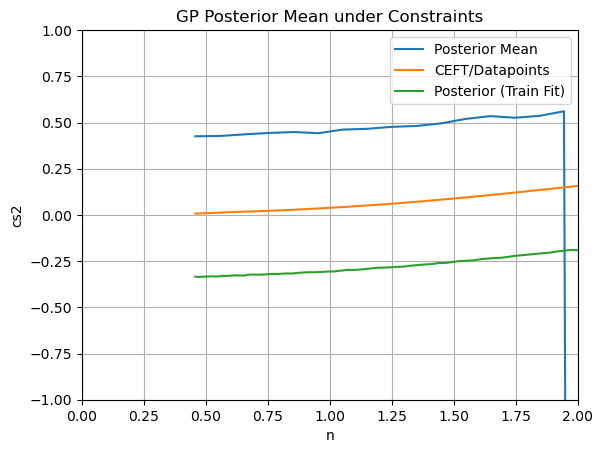

In [361]:
# 1. Extract components
zeta = mu_cond[0]           # Intercept
xi   = mu_cond[1:]          # Shape (101,)

# 3. Reconstruct the function
mu_fn = Phi_test @ xi + zeta  # Shape (100,)

# 4. Plot
import matplotlib.pyplot as plt

plt.plot(x_test/ns, mu_fn, label="Posterior Mean")
plt.plot(n_ceft,cs2_ceft, label = "CEFT/Datapoints")
plt.plot(n/ns, Phi @ mu_cond, label="Posterior (Train Fit)")

plt.xlabel("n")
plt.ylabel("cs2")
plt.title("GP Posterior Mean under Constraints")
plt.legend()
plt.grid(True)
plt.xlim(0,2)
plt.ylim(-1,1)
plt.show()


It cannot even fulfil the interpolation condition. Abandoning this method to move on to virtual points.

In [365]:
A_bounds = np.vstack([Phi, -Phi])         # Shape (2n, N+1)
b_bounds = np.hstack([np.zeros(numobs), -np.ones(numobs)])  # Shape (2n,)


In [373]:
from scipy.linalg import cholesky, cho_solve

L = cholesky(Sigma_cond + 1e-5 * np.eye(m), lower=True, check_finite=False)
Gamma_inv = cho_solve((L, True), np.eye(m), check_finite=False)
r = Gamma_inv @ xi

Q = Gamma_inv
c = -r

LinAlgError: 2-th leading minor of the array is not positive definite

In [367]:
import cvxpy as cp
import numpy as np

# Define dimensions
m = Gamma.shape[0]
xi = cp.Variable(m)

# Inverse covariance (you may add jitter if needed)
Gamma_inv = np.linalg.inv(Gamma + 1e-6 * np.eye(m))

# Objective function
objective = cp.Minimize(cp.quad_form(xi, Gamma_inv))

# Constraints
constraints = [
    Phi @ xi == cs2,
    Phi @ xi >= 0,
    Phi @ xi <= 1
]

# Problem
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.OSQP)  # or use ECOS, SCS, CLARABEL, etc.

if problem.status not in ["optimal", "optimal_inaccurate"]:
    raise RuntimeError(f"QP failed: {problem.status}")

mu_star = xi.value


ArpackNoConvergence: ARPACK error -1: ARPACK error -1: No convergence (1521 iterations, 0/1 eigenvectors converged)


        CVXPY note: This failure was encountered while trying to certify
        that a matrix is positive semi-definite (see [1] for a definition).
        In rare cases, this method fails for numerical reasons even when the matrix is
        positive semi-definite. If you know that you're in that situation, you can
        replace the matrix A by cvxpy.psd_wrap(A).

        [1] https://en.wikipedia.org/wiki/Definite_matrix
        